This notebook shows the yelp dataset start rating classification problem.
The objective is to predict the star rating based on the:
- business review count
- total number of checkins
- state where business is located
- city where business is located

In [9]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

np.random.seed(42)


## 1. Load Data

In [2]:
df_business = pd.read_json('../../data/business.json',lines=True)
df_checkin = pd.read_json('../../data/checkin.json', lines=True)

## 2. Exploratory Data Analysis (EDA)

In [3]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
address         192609 non-null object
attributes      163773 non-null object
business_id     192609 non-null object
categories      192127 non-null object
city            192609 non-null object
hours           147779 non-null object
is_open         192609 non-null int64
latitude        192609 non-null float64
longitude       192609 non-null float64
name            192609 non-null object
postal_code     192609 non-null object
review_count    192609 non-null int64
stars           192609 non-null float64
state           192609 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB


In [4]:
df_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [5]:
total = df_business.isnull().sum().sort_values(ascending=False)
percent = (df_business.isnull().sum()/df_business.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)
missing_data

,Total,Percent
hours,44830,0.303358
attributes,28836,0.176073
categories,482,0.002509
state,0,0.000000
stars,0,0.000000
review_count,0,0.000000
postal_code,0,0.000000
name,0,0.000000
longitude,0,0.000000
latitude,0,0.000000


In [7]:
df_business = df_business.dropna()

In [8]:
df_business['review_count'].describe()

count    129268.000000
mean         44.508370
std         131.780404
min           3.000000
25%           6.000000
50%          13.000000
75%          36.000000
max        8348.000000
Name: review_count, dtype: float64

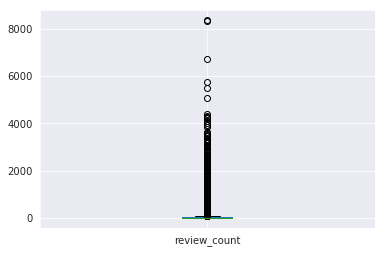

In [10]:
df_business[['review_count']].boxplot()
pyplot.show()

In [6]:
df_business['review_count'] = df_business['review_count'].fillna(0)

In [7]:
df_business['stars'] = df_business['stars'].fillna(0)

In [8]:
df_business.describe()

,is_open,latitude,longitude,review_count,stars
count,129268.000000,129268.000000,129268.000000,129268.000000,129268.000000
mean,0.843565,38.348179,-97.976657,44.508370,3.712644
std,0.363268,4.867658,16.625511,131.780404,0.934989
min,0.000000,33.204642,-115.477519,3.000000,1.000000
25%,1.000000,33.625583,-112.272915,6.000000,3.000000
50%,1.000000,36.127674,-111.790583,13.000000,4.000000
75%,1.000000,43.112978,-80.037140,36.000000,4.500000
max,1.000000,51.296592,-72.945050,8348.000000,5.000000


In [9]:
stars = df_business.groupby('stars').mean()

In [10]:
stars.corr()

,is_open,latitude,longitude,review_count
is_open,1.000000,-0.886744,-0.864017,-0.575509
latitude,-0.886744,1.000000,0.995357,0.413856
longitude,-0.864017,0.995357,1.000000,0.366235
review_count,-0.575509,0.413856,0.366235,1.000000


In [11]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 1 to 192608
Data columns (total 14 columns):
address         129268 non-null object
attributes      129268 non-null object
business_id     129268 non-null object
categories      129268 non-null object
city            129268 non-null object
hours           129268 non-null object
is_open         129268 non-null int64
latitude        129268 non-null float64
longitude       129268 non-null float64
name            129268 non-null object
postal_code     129268 non-null object
review_count    129268 non-null int64
stars           129268 non-null float64
state           129268 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 14.8+ MB


In [12]:
numeric_features = df_business.loc[:, ['latitude', 'longitude', 'review_count', 'stars']]

In [13]:
numeric_features_standardized = (numeric_features)/numeric_features.max()

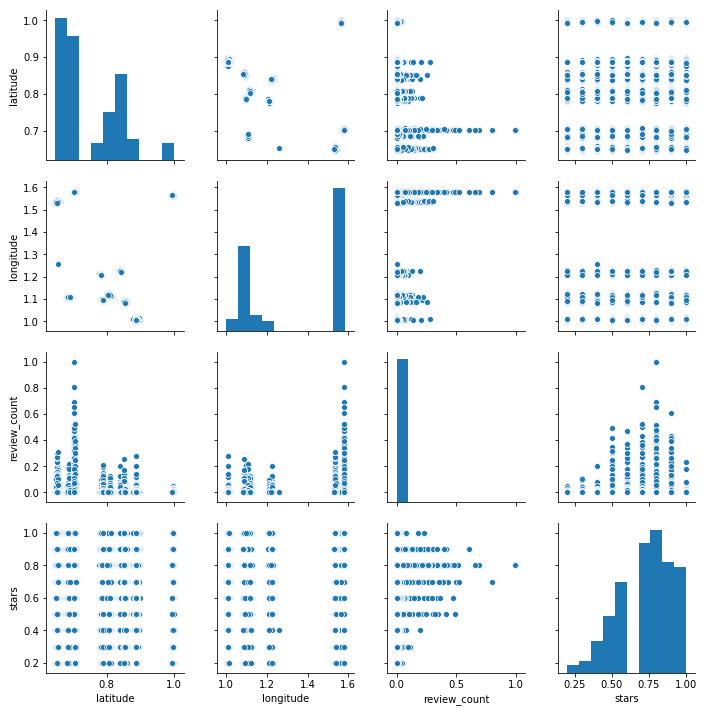

In [14]:
ax = sns.pairplot(numeric_features_standardized)
plt.show()

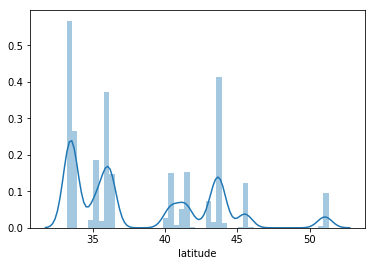

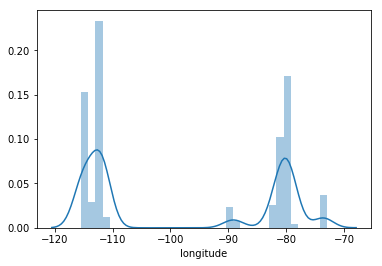

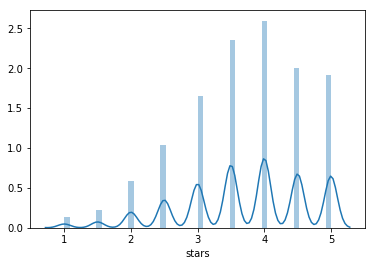

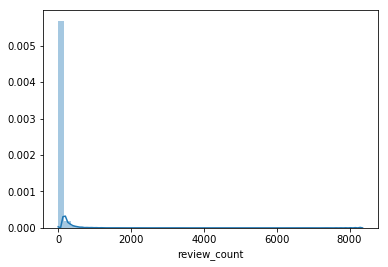

In [15]:
ax = sns.distplot(df_business['latitude'])
plt.show()
ax = sns.distplot(df_business['longitude'])
plt.show()
ax = sns.distplot(df_business['stars'])
plt.show()
ax = sns.distplot(df_business['review_count'])
plt.show()

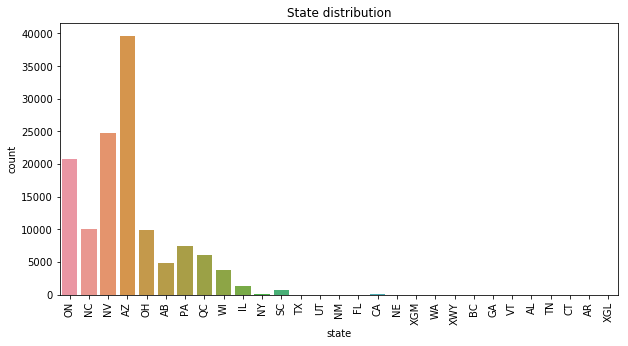

In [16]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='state', data=df_business)
plt.xticks(rotation='vertical')
plt.title('State distribution')
plt.show()

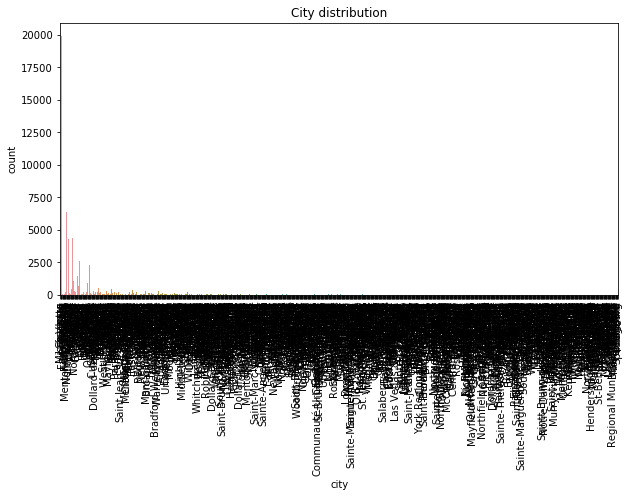

In [17]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='city', data=df_business)
plt.xticks(rotation='vertical')
plt.title('City distribution')
plt.show()

In [18]:
df_business["stars"].value_counts()

4.0    26830
3.5    24301
4.5    20761
5.0    19854
3.0    17020
2.5    10756
2.0     6033
1.5     2258
1.0     1455
Name: stars, dtype: int64

In [19]:
df_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161950 entries, 0 to 161949
Data columns (total 2 columns):
business_id    161950 non-null object
date           161950 non-null object
dtypes: object(2)
memory usage: 2.5+ MB


In [20]:
df_checkin.head()

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."


In [21]:
#from datetime import datetime
#datetime_object = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [22]:
def get_checkin_count(x):
    return len(x.split(", "))

df_checkin['checkin_count'] = df_checkin['date'].apply(get_checkin_count)

In [23]:
df_checkin.head()

,business_id,date,checkin_count
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016...",6
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012...",167
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015...",180
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30,1
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010...",37


In [24]:
len(df_checkin["checkin_count"].unique())

2884

## 3. Prepare Data

In [25]:
df_merged = pd.merge(df_business, df_checkin, on='business_id', how='left')

In [26]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 16 columns):
address          129268 non-null object
attributes       129268 non-null object
business_id      129268 non-null object
categories       129268 non-null object
city             129268 non-null object
hours            129268 non-null object
is_open          129268 non-null int64
latitude         129268 non-null float64
longitude        129268 non-null float64
name             129268 non-null object
postal_code      129268 non-null object
review_count     129268 non-null int64
stars            129268 non-null float64
state            129268 non-null object
date             113701 non-null object
checkin_count    113701 non-null float64
dtypes: float64(4), int64(2), object(10)
memory usage: 16.8+ MB


In [27]:
df_merged.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,date,checkin_count
0,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON,"2010-07-05 16:56:31, 2010-12-21 20:30:01, 2010...",455.0
1,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC,"2010-11-13 01:00:36, 2010-12-19 00:49:15, 2011...",721.0
2,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC,NaN,NaN
3,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': '{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",1,43.599475,-79.711584,The UPS Store,L5V 0B1,3,2.5,ON,"2014-03-31 21:46:17, 2015-01-27 19:05:03, 2018...",3.0
4,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.099872,-115.074574,Supercuts,89121,3,3.5,NV,"2011-05-21 22:20:31, 2011-10-05 21:34:47, 2012...",11.0


In [28]:
df_merged[['checkin_count']] = df_merged[['checkin_count']].fillna(0)

In [29]:
df_merged.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,date,checkin_count
0,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON,"2010-07-05 16:56:31, 2010-12-21 20:30:01, 2010...",455.0
1,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC,"2010-11-13 01:00:36, 2010-12-19 00:49:15, 2011...",721.0
2,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC,NaN,0.0
3,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': '{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",1,43.599475,-79.711584,The UPS Store,L5V 0B1,3,2.5,ON,"2014-03-31 21:46:17, 2015-01-27 19:05:03, 2018...",3.0
4,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.099872,-115.074574,Supercuts,89121,3,3.5,NV,"2011-05-21 22:20:31, 2011-10-05 21:34:47, 2012...",11.0


In [30]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 16 columns):
address          129268 non-null object
attributes       129268 non-null object
business_id      129268 non-null object
categories       129268 non-null object
city             129268 non-null object
hours            129268 non-null object
is_open          129268 non-null int64
latitude         129268 non-null float64
longitude        129268 non-null float64
name             129268 non-null object
postal_code      129268 non-null object
review_count     129268 non-null int64
stars            129268 non-null float64
state            129268 non-null object
date             113701 non-null object
checkin_count    129268 non-null float64
dtypes: float64(4), int64(2), object(10)
memory usage: 16.8+ MB


In [31]:
df_merged_new = df_merged[['business_id','review_count', 'stars', 'checkin_count', 'city', 'state', 'categories']]
df_merged_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 7 columns):
business_id      129268 non-null object
review_count     129268 non-null int64
stars            129268 non-null float64
checkin_count    129268 non-null float64
city             129268 non-null object
state            129268 non-null object
categories       129268 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 7.9+ MB


In [32]:
df_merged_new['stars'] = df_merged_new['stars'].round()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
df_merged_new['stars'].value_counts()

4.0    71892
5.0    19854
2.0    19047
3.0    17020
1.0     1455
Name: stars, dtype: int64

In [34]:
df_merged_new['review_count'] = df_merged_new['review_count'].fillna(0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 4. Train Models

#### Normalize numeric features

In [35]:
from sklearn.preprocessing import StandardScaler

cols_to_norm = ['review_count', 'checkin_count']
#new_df[cols_to_norm] = new_df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

dict_scaler = {}
for col_to_norm in cols_to_norm:
    scaler = StandardScaler()
    scaler.fit(df_merged_new.loc[:, col_to_norm].values.reshape(-1, 1))
    df_merged_new.loc[:,col_to_norm] = scaler.transform(df_merged_new.loc[:,col_to_norm].values.reshape(-1, 1))
    dict_scaler[col_to_norm] = scaler  

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

#### Transform features of types string to integer

In [36]:
from sklearn import preprocessing

cols_str_to_int = ['state', 'city']
for col_str_to_int in cols_str_to_int:
    label_encoder = preprocessing.LabelEncoder()
    df_merged_new[col_str_to_int] = label_encoder.fit_transform(df_merged_new[col_str_to_int])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
df_merged_new.head()

,business_id,review_count,stars,checkin_count,city,state,categories
0,QXAEGFB4oINsVuTFxEYKFQ,0.633569,2.0,0.398021,481,16,"Specialty Food, Restaurants, Dim Sum, Imported..."
1,gnKjwL_1w79qoiV3IC_xQQ,0.952282,4.0,0.726081,129,10,"Sushi Bars, Restaurants, Japanese"
2,HhyxOkGAM07SRYtlQ4wMFQ,-0.307394,4.0,-0.163135,129,10,"Plumbing, Shopping, Local Services, Home Servi..."
3,68dUKd8_8liJ7in4aWOSEA,-0.314983,2.0,-0.159435,481,16,"Shipping Centers, Couriers & Delivery Services..."
4,gbQN7vr_caG_A1ugSmGhWg,-0.314983,4.0,-0.149568,366,13,"Hair Salons, Hair Stylists, Barbers, Men's Hai..."


In [38]:
df_merged_new['categories_str'] = df_merged_new['categories'].apply(lambda x:x.replace(',', ''))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
df_merged_new.head()

,business_id,review_count,stars,checkin_count,city,state,categories,categories_str
0,QXAEGFB4oINsVuTFxEYKFQ,0.633569,2.0,0.398021,481,16,"Specialty Food, Restaurants, Dim Sum, Imported...",Specialty Food Restaurants Dim Sum Imported Fo...
1,gnKjwL_1w79qoiV3IC_xQQ,0.952282,4.0,0.726081,129,10,"Sushi Bars, Restaurants, Japanese",Sushi Bars Restaurants Japanese
2,HhyxOkGAM07SRYtlQ4wMFQ,-0.307394,4.0,-0.163135,129,10,"Plumbing, Shopping, Local Services, Home Servi...",Plumbing Shopping Local Services Home Services...
3,68dUKd8_8liJ7in4aWOSEA,-0.314983,2.0,-0.159435,481,16,"Shipping Centers, Couriers & Delivery Services...",Shipping Centers Couriers & Delivery Services ...
4,gbQN7vr_caG_A1ugSmGhWg,-0.314983,4.0,-0.149568,366,13,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Hair Salons Hair Stylists Barbers Men's Hair S...


In [40]:
categories = set((', '.join(df_merged_new['categories'].tolist())).strip().split(', '))
len(categories)

1279

In [41]:
categories

{'Comfort Food',
 'Vintage & Consignment',
 'Limos',
 'Wholesale Stores',
 'Osteopaths',
 'Vocal Coach',
 'Guest Houses',
 'Airports',
 'Concierge Medicine',
 'Petting Zoos',
 'Landscape Architects',
 'Kiosk',
 'Jazz & Blues',
 'Poke',
 'Dominican',
 'Telecommunications',
 'Herbal Shops',
 'Public Relations',
 'Outdoor Movies',
 'Tanning Beds',
 'Boat Repair',
 'Virtual Reality Centers',
 'Casinos',
 'Rolfing',
 'African',
 'Golf Cart Rentals',
 'Shoe Stores',
 'Water Stores',
 'Tex-Mex',
 'Arts & Crafts',
 'Races & Competitions',
 'Farm Equipment Repair',
 'Pretzels',
 'Hospitals',
 'Cryotherapy',
 'Car Buyers',
 'Graphic Design',
 'Health Insurance Offices',
 'Chicken Wings',
 'Pathologists',
 'Sex Therapists',
 'Departments of Motor Vehicles',
 'Antiques',
 'Lakes',
 'Radiologists',
 'Syrian',
 'Mosques',
 'Music & Video',
 'Stucco Services',
 'Public Markets',
 'Car Rental',
 'Boat Parts & Supplies',
 'Cooking Schools',
 'Blow Dry/Out Services',
 'Distilleries',
 'Paddleboarding',


#### TODO: one-hot encoding
Due to limited computational resource, the categorical feature one-hot encoding is put into the todo list.

#### Text feature extraction 
https://scikit-learn.org/stable/modules/feature_extraction.html
https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [42]:
#https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=100, min_df=2)
x = vectorizer.fit_transform(categories)

df_temp = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())
print(df_temp)

df_merged_new_tfid = pd.concat([df_merged_new, df_temp], axis=1)
print(df_merged_new_tfid)

print(vectorizer.vocabulary_)
print(vectorizer.idf_)

      agents  american  animal  art  artists  arts  auto  bars  beer  \
0        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
1        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
2        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
3        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
4        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
5        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
6        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
7        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
8        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
9        0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
10       0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
11       0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0   0.0   
12       0.0       0.0     0.0  0.0      0.0   0.0   0.0   0.0  

                   business_id  review_count  stars  checkin_count  city  \
0       QXAEGFB4oINsVuTFxEYKFQ      0.633569    2.0       0.398021   481   
1       gnKjwL_1w79qoiV3IC_xQQ      0.952282    4.0       0.726081   129   
2       HhyxOkGAM07SRYtlQ4wMFQ     -0.307394    4.0      -0.163135   129   
3       68dUKd8_8liJ7in4aWOSEA     -0.314983    2.0      -0.159435   481   
4       gbQN7vr_caG_A1ugSmGhWg     -0.314983    4.0      -0.149568   366   
5       Y6iyemLX_oylRpnr38vgMA     -0.277041    5.0      -0.118735   275   
6       4GBVPIYRvzGh4K4TkRQ_rw     -0.277041    4.0      -0.154501   242   
7       fcXOEZdXYeZqnQ3lGlOXmg     -0.299806    2.0      -0.160668   107   
8       1Dfx3zM-rW4n-31KeC8sJg     -0.201156    3.0      -0.052137   641   
9       5t3KVdMnFgAYmSl1wYLhmA     -0.269452    4.0      -0.102702   514   
10      fweCYi8FmbJXHCqLnwuk8w     -0.216333    4.0      -0.156968   460   
11      -K4gAv8_vjx8-2BxkVeRkA     -0.284629    3.0      -0.145868   943   
12      A98x

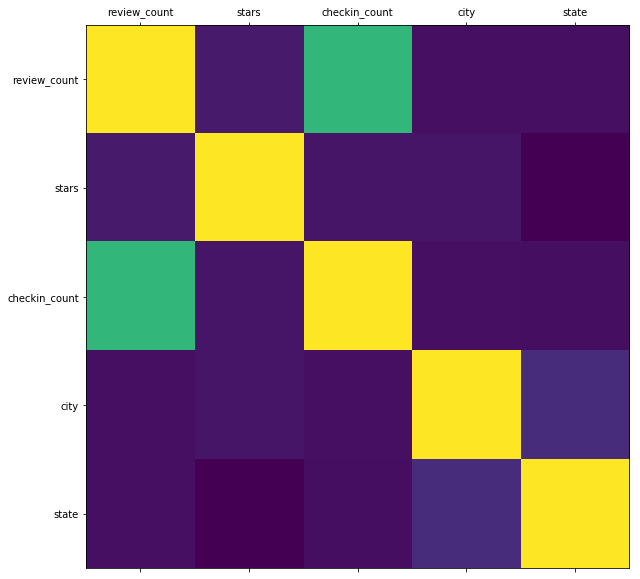

In [43]:
corr = df_merged_new.corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

plt.show()

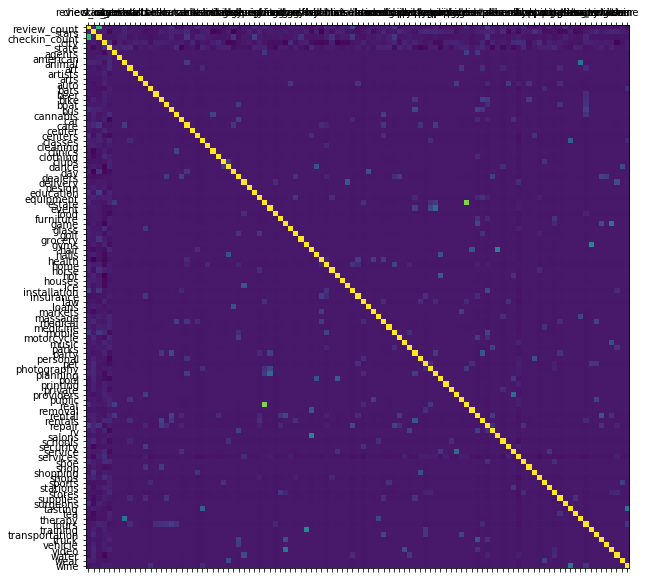

In [44]:
corr = df_merged_new_tfid.corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

plt.show()

### Predict star ratings without using category text features

In [45]:
X = df_merged_new[['review_count', 'checkin_count', 'city', 'state']]
Y = df_merged_new['stars'].apply(int).tolist()

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 4 columns):
review_count     129268 non-null float64
checkin_count    129268 non-null float64
city             129268 non-null int64
state            129268 non-null int64
dtypes: float64(2), int64(2)
memory usage: 4.9 MB


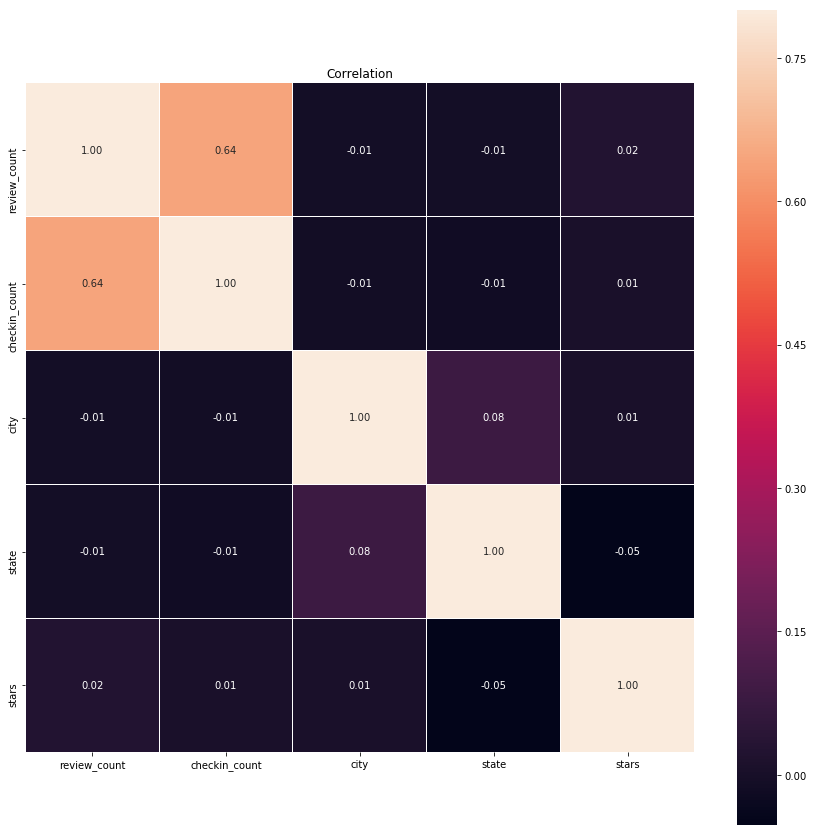

In [46]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df_merged_new[['review_count', 'checkin_count', 'city', 'state', 'stars']].corr(), vmax=.8, square=True, fmt='.2f', annot=True, linecolor='white', linewidths=0.01)
plt.title('Correlation')
plt.show()

In [58]:
df_merged_new['stars'].value_counts()

4.0    71892
5.0    19854
2.0    19047
3.0    17020
1.0     1455
Name: stars, dtype: int64

In [47]:
X.shape

(129268, 4)

In [48]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

#scaler = StandardScaler()
#X_tfid = scaler.fit_transform(X_tfid)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

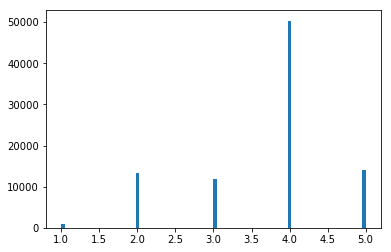

In [68]:
plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [72]:
import collections
ctr = collections.Counter(y_train)
print("Frequency of the elements in the List : ",ctr)

Frequency of the elements in the List :  Counter({4: 50345, 5: 13988, 2: 13253, 3: 11891, 1: 1010})


From the plots, it shows that the numbers of samples of each class are imbalanced. We have only 1010 samples with 1 star. We have 50345 samples with 4 stars.

In [50]:
X_tfid = df_merged_new_tfid[['review_count', 'checkin_count', 'city', 'state'] + vectorizer.get_feature_names()]

X_tfid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Columns: 104 entries, review_count to wine
dtypes: float64(102), int64(2)
memory usage: 103.6 MB


In [51]:
X_tfid.fillna(0, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [52]:
X_train_tfid, X_test_tfid, y_train, y_test = train_test_split(X_tfid, Y, test_size=0.3, random_state=42)

In [53]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
random_forest.fit(X_train, y_train)

y_predict = random_forest.predict(X_test)

predictions = [round(value) for value in y_predict]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('accuracy: {}'.format(round(accuracy, 3)))

print(f1_score(y_test, y_predict, average='macro'))  
print(f1_score(y_test, y_predict, average='micro'))
print(f1_score(y_test, y_predict, average='weighted'))  
print(f1_score(y_test, y_predict, average=None))

pd.DataFrame(confusion_matrix(y_test, y_predict))

print(classification_report(y_test, y_predict))

accuracy: 0.568
0.2102725382723511
0.5675975348753255
0.4496985157614874
[0.         0.         0.         0.71886133 0.33250136]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       445
           2       0.00      0.00      0.00      5794
           3       0.00      0.00      0.00      5129
           4       0.58      0.95      0.72     21547
           5       0.46      0.26      0.33      5866

   micro avg       0.57      0.57      0.57     38781
   macro avg       0.21      0.24      0.21     38781
weighted avg       0.39      0.57      0.45     38781



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classi

In [54]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
random_forest.fit(X_train_tfid.values, y_train)

y_predict_tfid = random_forest.predict(X_test_tfid)

predictions = [round(value) for value in y_predict_tfid]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('accuracy: {}'.format(round(accuracy, 3)))

print(f1_score(y_test, y_predict_tfid, average='macro'))  
print(f1_score(y_test, y_predict_tfid, average='micro'))
print(f1_score(y_test, y_predict_tfid, average='weighted'))  
print(f1_score(y_test, y_predict_tfid, average=None))

pd.DataFrame(confusion_matrix(y_test, y_predict_tfid))

print(classification_report(y_test, y_predict_tfid))

accuracy: 0.556
0.14286566768333114
0.5556071272014647
0.39688591598627365
[0.         0.         0.         0.71432834 0.        ]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       445
           2       0.00      0.00      0.00      5794
           3       0.00      0.00      0.00      5129
           4       0.56      1.00      0.71     21547
           5       0.00      0.00      0.00      5866

   micro avg       0.56      0.56      0.56     38781
   macro avg       0.11      0.20      0.14     38781
weighted avg       0.31      0.56      0.40     38781



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classi

In [55]:
!pip install xgboost
!pip install hyperopt

    100% |████████████████████████████████| 114.0MB 112kB/s eta 0:00:01   79% |█████████████████████████▋      | 91.1MB 17.8MB/s eta 0:00:02��██████████████▉    | 99.0MB 42.9MB/s eta 0:00:01.2MB 37.8MB/s eta 0:00:01
    100% |████████████████████████████████| 122kB 2.5MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 17.0MB/s ta 0:00:01
    100% |████████████████████████████████| 409kB 6.8MB/s ta 0:00:011
    100% |████████████████████████████████| 829kB 22.5MB/s ta 0:00:01█▊                     | 276kB 12.6MB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future


In [56]:
import xgboost
from xgboost import XGBClassifier

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime

# hyperparameter tuning
# reference: 
# https://machinelearningmastery.com/xgboost-python-mini-course/
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost/code
# https://xgboost-clone.readthedocs.io/en/latest/parameter.html

def timer(start_time=None):
    # fork from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
folds = 5
param_comb = 3

xgb_clf = XGBClassifier(silent=True)
params = {
            'n_estimators': [5, 50, 100, 200],
            'min_child_weight': [1, 5, 10],
            # 'gamma': [0.5, 1, 1.5, 2, 5],
            # 'subsample': [0.6, 0.8, 1.0],
            #'subsample': [0.6, 0.8, 1],
            # 'colsample_bytree': [0.6, 0.8, 1.0],
            # 'colsample_bytree': [0.6, 0.8, 1],
            # 'max_depth': [3, 4, 5]
            'max_depth': [2, 4, 6],
        }

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

search = RandomizedSearchCV(xgb_clf, 
                            param_distributions=params, 
                            n_iter=param_comb, 
                            #scoring='roc_auc', # binary classification
                            scoring='accuracy',
                            #n_jobs=-1,
                            n_jobs=2,
                            cv=skf.split(X_train, y_train),
                            verbose=3, random_state=42)

# search = GridSearchCV(model, params, scoring="neg_log_loss", n_jobs=-1, cv=skf)

start_time = timer(None)
search.fit(X_train, y_train)
timer(start_time)

print('--------------')
print('\n all results:')
print(search.cv_results_)

print('\n best estimator:')
print(search.best_estimator_)

print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(search.best_score_ * 2 - 1)

print('\n best xgb hyperparameters:')
print(search.best_params_)

result_csv_path = 'xgb-search-results.csv'
results = pd.DataFrame(search.cv_results_)
results.to_csv(result_csv_path, index=False)
print('save xgb search results to {}'.format(result_csv_path))
print('--------------')

#y_pred = search.predict_proba(X_test)
#y_pred = np.argmax(y_pred)
y_pred = search.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('accuracy: {}'.format(round(accuracy, 3)))

print(f1_score(y_test, predictions, average='macro'))  
print(f1_score(y_test, predictions, average='micro'))
print(f1_score(y_test, predictions, average='weighted'))  
print(f1_score(y_test, predictions, average=None))

conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

print(classification_report(y_test, predictions))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:  1.5min finished



 Time taken: 0 hours 1 minutes and 52.85 seconds.
--------------

 all results:
{'mean_fit_time': array([27.07673971,  5.17981855, 14.39133175]), 'std_fit_time': array([0.10824077, 0.20574916, 0.05762524]), 'mean_score_time': array([2.18219002, 0.30127549, 1.04800963]), 'std_score_time': array([0.12141626, 0.01326868, 0.02048288]), 'param_n_estimators': masked_array(data=[200, 50, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10, 1, 1],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[6, 4, 6],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 6}, {'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 4}, {'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6}], 'split0_test_score': array([0.5716

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py

accuracy: 0.569
0.21722240545184324
0.5688352543771434
0.45499858716712427
[0.         0.00445434 0.00155219 0.71906331 0.36104218]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[    0     5     0   312   128]
 [    0    13     2  5311   468]
 [    0     3     4  4873   249]
 [    0    17    18 20297  1215]
 [    0     5     1  4114  1746]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       445
           2       0.30      0.00      0.00      5794
           3       0.16      0.00      0.00      5129
           4       0.58      0.94      0.72     21547
           5       0.46      0.30      0.36      5866

   micro avg       0.57      0.57      0.57     38781
   macro avg       0.30      0.25      0.22     38781
weighted avg       0.46      0.57      0.45     38781



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
